PU comparison

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from glob import glob
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy.optimize import minimize
import uproot as ur
import ROOT as rt
import root_numpy as rtnp
import ROOT.RooFit as rf
from scipy.special import erf
import sys, os, yaml
sys.path.append('../lib')
sys.path.append('../analysis')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from lumi_utilities import getLumiByTrigger
from cebefo_style import Set_2D_colz_graphics
from progressBar import ProgressBar
from array import array
from categoriesDef import categories

from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader
from lumi_utilities import getLumiReport

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Internal"

donotdelete = []

Welcome to JupyROOT 6.12/07


In [2]:
# load FWLite C++ libraries
rt.gSystem.Load("libFWCoreFWLite.so");
rt.gSystem.Load("libDataFormatsFWLite.so");
rt.FWLiteEnabler.enable()

# load FWlite python libraries
from DataFormats.FWLite import Events
from DataFormats.FWLite import Handle

In [3]:
from prettytable import PrettyTable

In [4]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [5]:
m_D0 = 1.86483 #1e-3*Particle.from_string('D0').mass
print m_D0
m_Dst = 2.01026 #1e-3*Particle.from_string('D*+').mass
print m_Dst
m_B0 = 5.27963 #1e-3*Particle.from_string('B0').mass
print m_B0
m_pi = 0.13957018 #1e-3*Particle.from_string('pi+').mass
print 'mD* - mD0 =', m_Dst - m_D0

1.86483
2.01026
5.27963
mD* - mD0 = 0.14543


In [6]:
colors = [rt.kBlack, rt.kAzure+1, rt.kRed-4, rt.kGreen+1, rt.kViolet-7]

In [7]:
cl = rt.TLine()
cl.SetLineColor(6)
cl.SetLineStyle(9)
cl.SetLineWidth(2)

# Get MC

In [8]:
cat = categories['low']

In [9]:
#They all have to be produced with the same pileup
MCsample = {
'mu' : DSetLoader('B0_MuNuDmst_PUc0'),
# 'tau' : DSetLoader('B0_TauNuDmst_PUc0'),
'Hc' : DSetLoader('B0_DmstHc_PUc0'),
'DstPip' : DSetLoader('Bp_MuNuDstst_Pip_PUc0'),
# 'DstPi0' : DSetLoader('B0_MuNuDstst_Pi0_PUc0'),
# 'DstPi0' : DSetLoader('B0_DmstPi0MuNu_PUc0'),
# 'DstPipPi0' : DSetLoader('Bp_MuNuDstst_PipPi0_PUc0'),
# 'DstPipPim' : DSetLoader('B0_MuNuDstst_PipPim_PUc0'),
# 'DstPi0Pi0' : DSetLoader('B0_MuNuDstst_Pi0Pi0_PUc0'),
}
df = {}
for n, s in MCsample.iteritems():
    df[n] = pd.DataFrame(rtnp.root2array(s.skimmed_dir + '/{}_skip17_corr.root'.format(cat.name)))

### Some MC plots

In [10]:
d = df['DstPip']

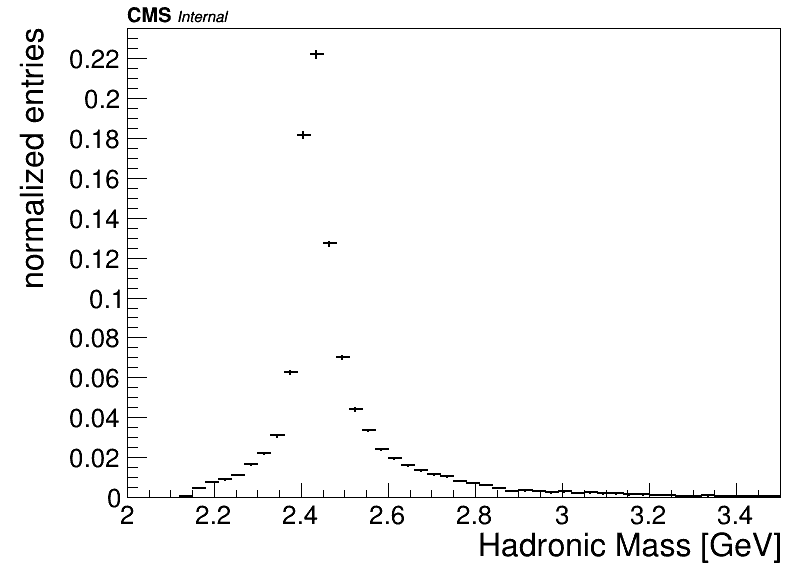

In [11]:
sel = np.logical_and(d['N_goodAddTks'] == 1, d['tkCharge_0'] > 0)
h = create_TH1D(d['tkMassHad_0'][sel], binning=[50, 2, 3.5], axis_title=['Hadronic Mass [GeV]', 'normalized entries'], scale_histo='norm')
c = drawOnCMSCanvas(CMS_lumi, [h])

In [12]:
np.sum(np.logical_and(d['MC_tkFlag_0'] == 1, sel))/float(np.sum(sel))

0.8811507524027313

In [13]:
selDstPi = np.logical_and(df['DstPip']['N_goodAddTks'] == 1, df['DstPip']['tkCharge_0'] > 0)
selDstPi = np.logical_and(df['DstPip']['MC_tkFlag_0'] == 1, selDstPi)
selMu = np.logical_and(df['mu']['N_goodAddTks'] == 1, df['mu']['tkCharge_0'] > 0)
selMu = np.logical_and(df['mu']['MC_tkFlag_0'] == 1, selMu)

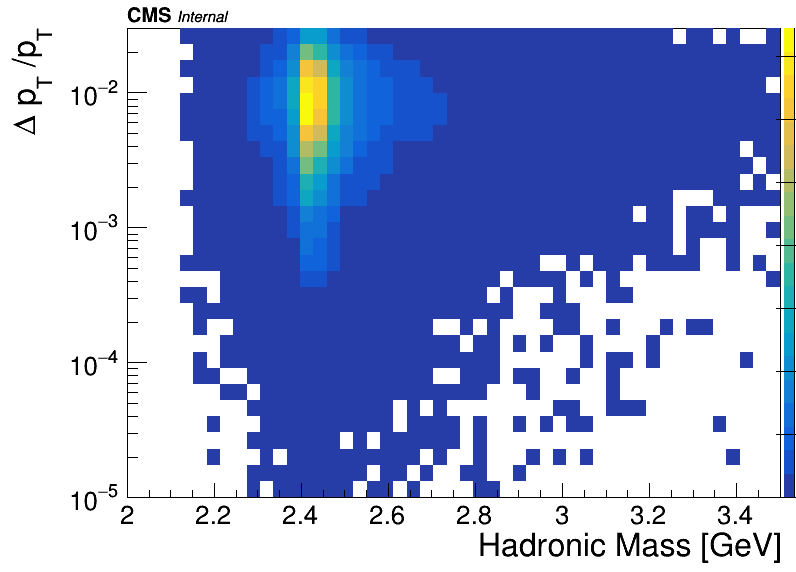

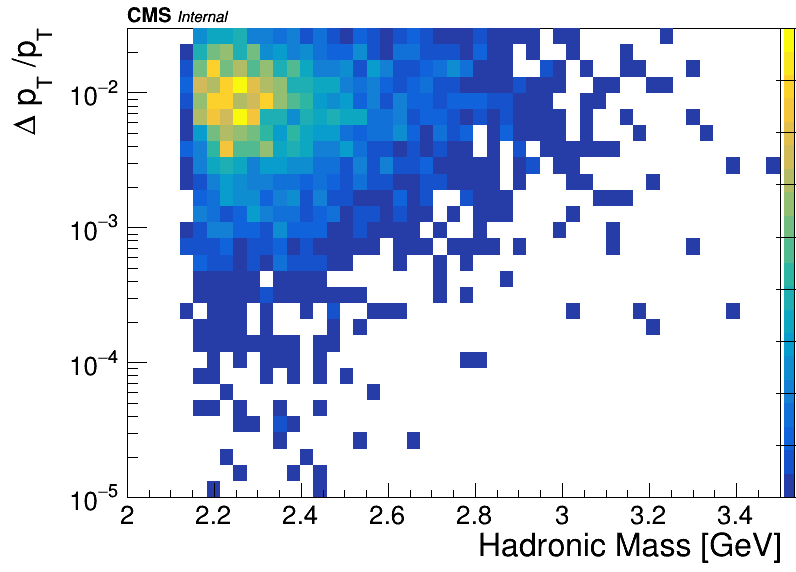

In [14]:
h = create_TH2D(np.column_stack((df['DstPip']['tkMassHad_0'][selDstPi], df['DstPip']['MC_tk_dpt_0'][selDstPi])), 'DstPip', 
                binning=[np.linspace(2, 3.5, 50), np.logspace(-5, np.log10(0.03), 30)], 
                axis_title=['Hadronic Mass [GeV]', '#Delta p_{T} /p_{T}', '']
               )
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], tag='DstPip')
c.SetLogy()

h1 = create_TH2D(np.column_stack((df['mu']['tkMassHad_0'][selMu], df['mu']['MC_tk_dpt_0'][selMu])), 'mu',
                binning=[np.linspace(2, 3.5, 50), np.logspace(-5, np.log10(0.03), 30)], 
                axis_title=['Hadronic Mass [GeV]', '#Delta p_{T} /p_{T}', '']
               )
c1 = drawOnCMSCanvas(CMS_lumi, [h1], ['colz'], tag='mu')
c1.SetLogy()

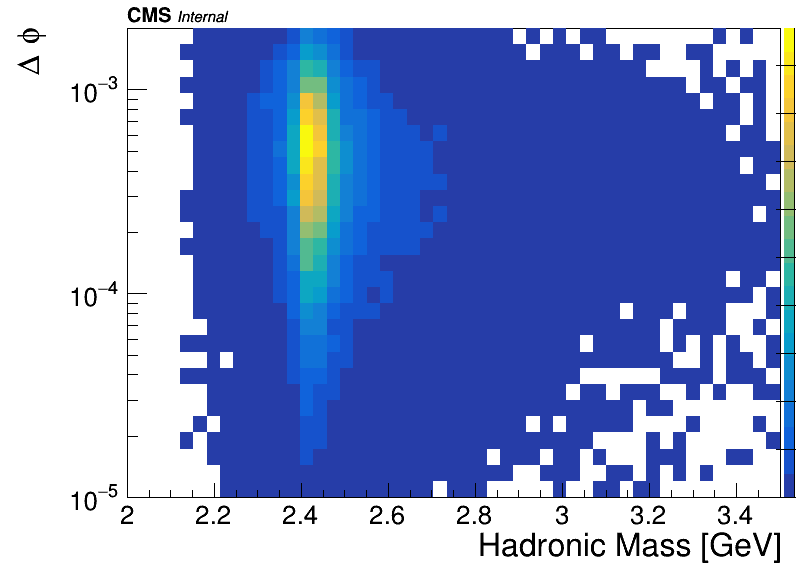

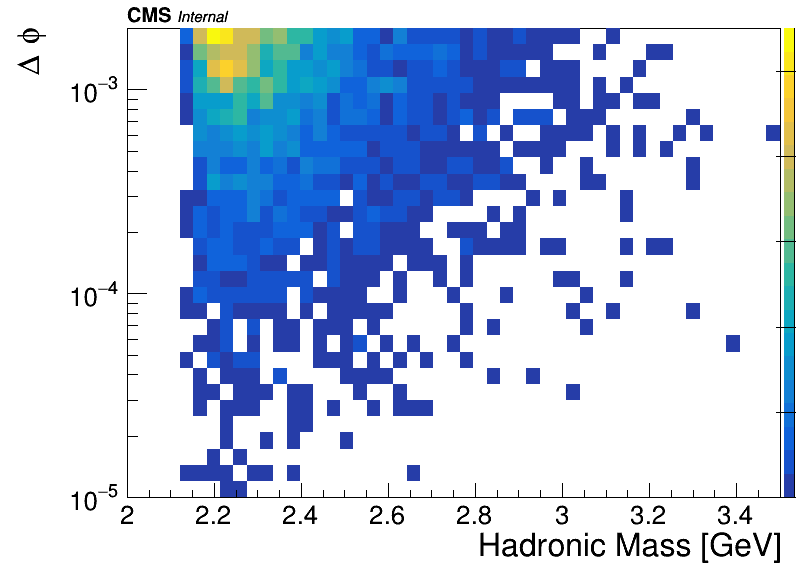

In [15]:
h = create_TH2D(np.column_stack((df['DstPip']['tkMassHad_0'][selDstPi], df['DstPip']['MC_tk_dphi_0'][selDstPi])), 'DstPip', 
                binning=[np.linspace(2, 3.5, 50), np.logspace(-5, np.log10(0.002), 30)],
                axis_title=['Hadronic Mass [GeV]', '#Delta #phi', '']
               )
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], tag='DstPip')
c.SetLogy()

h1 = create_TH2D(np.column_stack((df['mu']['tkMassHad_0'][selMu], df['mu']['MC_tk_dphi_0'][selMu])), 'mu',
                binning=[np.linspace(2, 3.5, 50), np.logspace(-5, np.log10(0.002), 30)],
                axis_title=['Hadronic Mass [GeV]', '#Delta #phi', '']
               )
c1 = drawOnCMSCanvas(CMS_lumi, [h1], ['colz'], tag='mu')
c1.SetLogy()

In [16]:
print np.sum(np.logical_and(df['DstPip']['MC_tk_dphi_0'] < 0.001, selDstPi))/float(np.sum(selDstPi))
print np.sum(np.logical_and(df['mu']['MC_tk_dphi_0'] < 0.001, selMu))/float(np.sum(selMu))

0.8879693653472713
0.5497335701598579


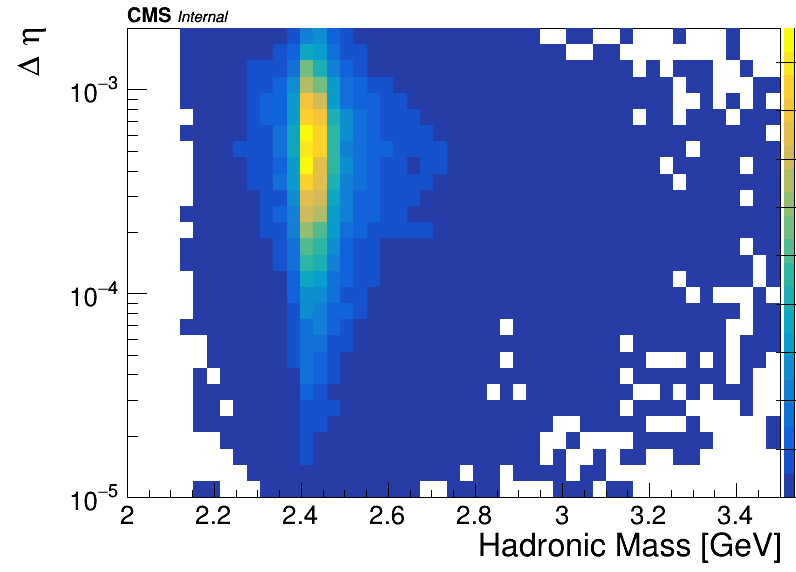

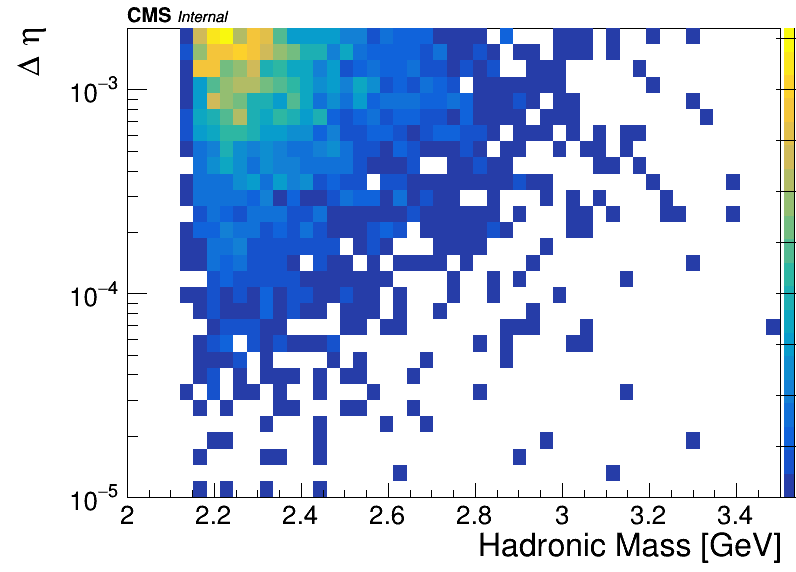

In [17]:
h = create_TH2D(np.column_stack((df['DstPip']['tkMassHad_0'][selDstPi], df['DstPip']['MC_tk_deta_0'][selDstPi])), 'DstPip', 
                binning=[np.linspace(2, 3.5, 50), np.logspace(-5, np.log10(0.002), 30)],
                axis_title=['Hadronic Mass [GeV]', '#Delta #eta', '']
               )
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], tag='DstPip')
c.SetLogy()

h1 = create_TH2D(np.column_stack((df['mu']['tkMassHad_0'][selMu], df['mu']['MC_tk_deta_0'][selMu])), 'mu',
                binning=[np.linspace(2, 3.5, 50), np.logspace(-5, np.log10(0.002), 30)],
                axis_title=['Hadronic Mass [GeV]', '#Delta #eta', '']
               )
c1 = drawOnCMSCanvas(CMS_lumi, [h1], ['colz'], tag='mu')
c1.SetLogy()

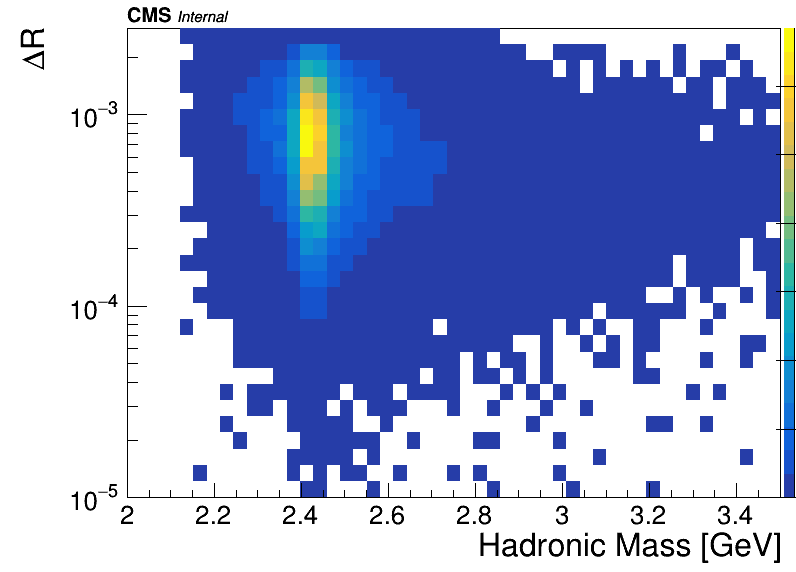

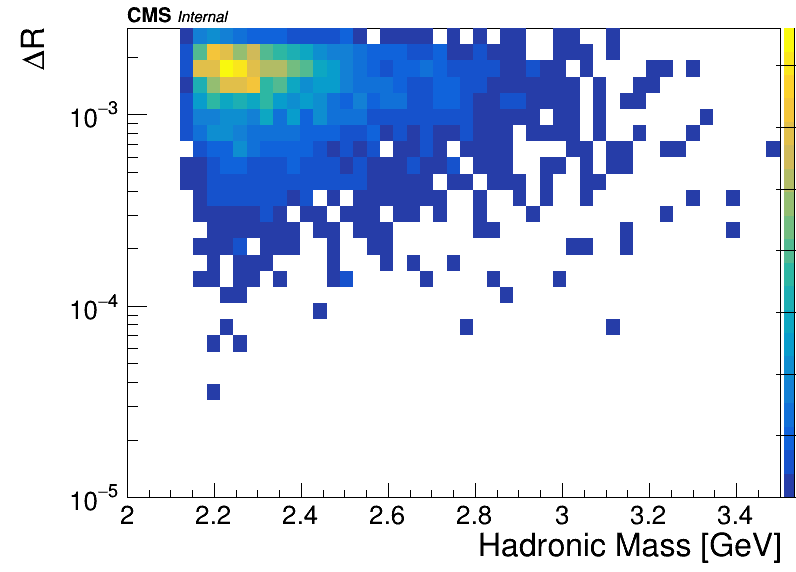

In [18]:
dRDstPi = np.hypot(df['DstPip']['MC_tk_deta_0'][selDstPi], df['DstPip']['MC_tk_dphi_0'][selDstPi])
h = create_TH2D(np.column_stack((df['DstPip']['tkMassHad_0'][selDstPi], dRDstPi)), 'DstPip', 
                binning=[np.linspace(2, 3.5, 50), np.logspace(-5, np.log10(0.002*np.sqrt(2)), 30)],
                axis_title=['Hadronic Mass [GeV]', '#DeltaR', '']
               )
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], tag='DstPip')
c.SetLogy()

dRMu = np.hypot(df['mu']['MC_tk_deta_0'][selMu], df['mu']['MC_tk_dphi_0'][selMu])
h1 = create_TH2D(np.column_stack((df['mu']['tkMassHad_0'][selMu], dRMu)), 'mu',
                binning=[np.linspace(2, 3.5, 50), np.logspace(-5, np.log10(0.002*np.sqrt(2)), 30)],
                axis_title=['Hadronic Mass [GeV]', '#DeltaR', '']
               )
c1 = drawOnCMSCanvas(CMS_lumi, [h1], ['colz'], tag='mu')
c1.SetLogy()

In [19]:
print np.sum(dRDstPi < 0.002)/float(np.sum(selDstPi))
print np.sum(dRMu < 0.002)/float(np.sum(selMu))

0.9819241030108347
0.8392539964476021


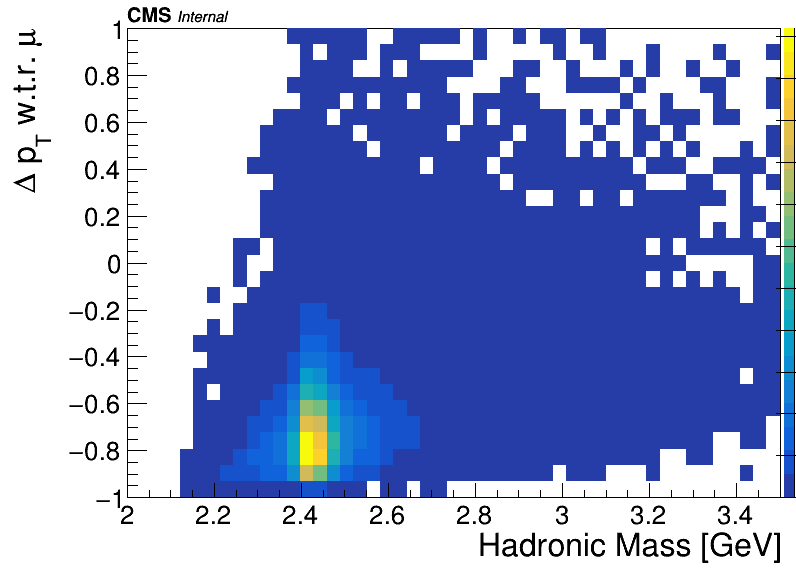

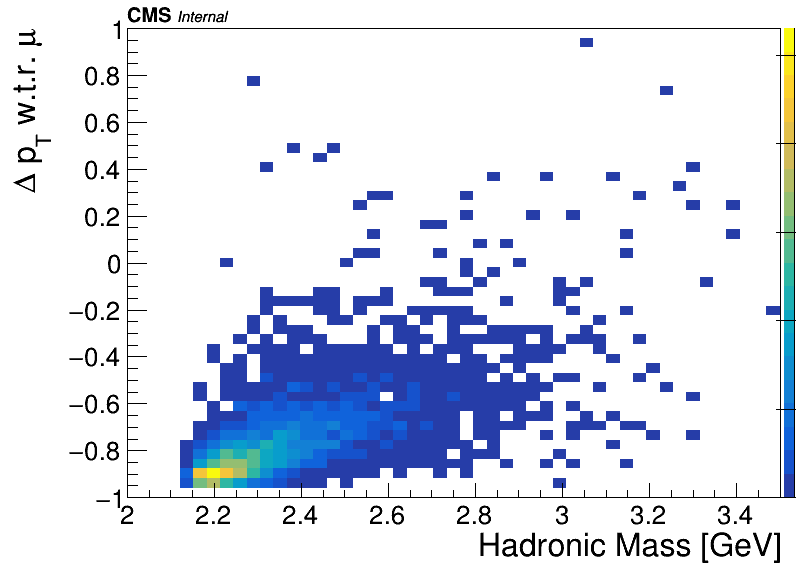

In [20]:
dRDstPi = (df['DstPip']['tkPt_0'][selDstPi] - df['DstPip']['mu_pt'][selDstPi])/df['DstPip']['mu_pt'][selDstPi]
h = create_TH2D(np.column_stack((df['DstPip']['tkMassHad_0'][selDstPi], dRDstPi)), 'DstPip', 
                binning=[np.linspace(2, 3.5, 50), np.linspace(-1, 1, 30)],
                axis_title=['Hadronic Mass [GeV]', '#Delta p_{T} w.t.r. #mu', '']
               )
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], tag='DstPip')

dRMu = (df['mu']['tkPt_0'][selMu] - df['mu']['mu_pt'][selMu])/df['mu']['mu_pt'][selMu]
h1 = create_TH2D(np.column_stack((df['mu']['tkMassHad_0'][selMu], dRMu)), 'mu',
                binning=[np.linspace(2, 3.5, 50), np.linspace(-1, 1, 50)],
                axis_title=['Hadronic Mass [GeV]', '#Delta p_{T} w.t.r. #mu', '']
               )
c1 = drawOnCMSCanvas(CMS_lumi, [h1], ['colz'], tag='mu')

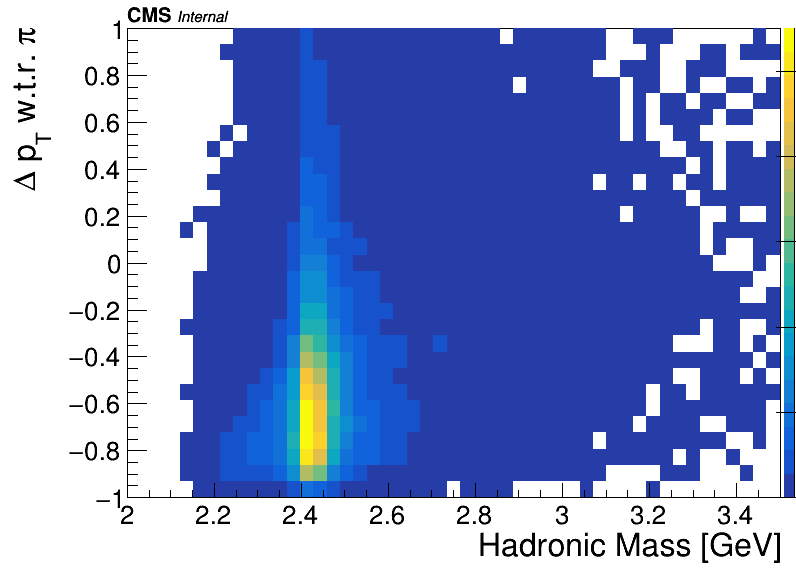

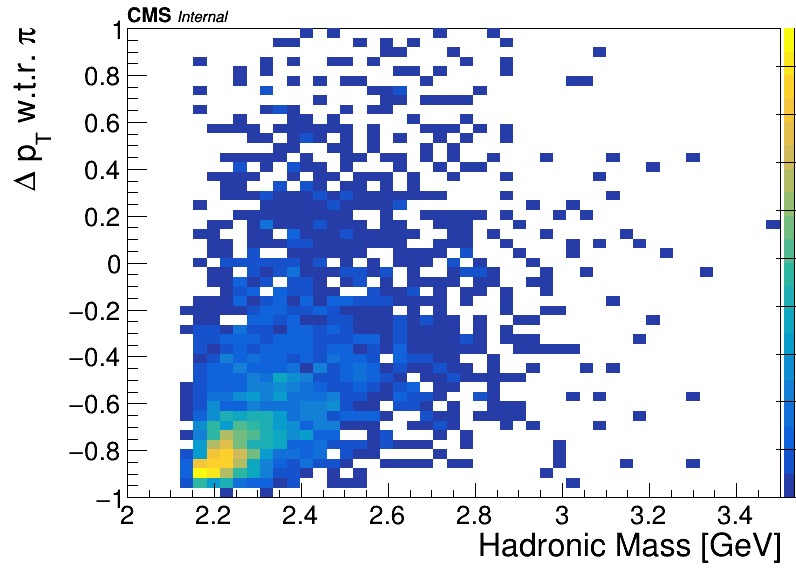

In [21]:
dRDstPi = (df['DstPip']['tkPt_0'][selDstPi] - df['DstPip']['pi_pt'][selDstPi])/df['DstPip']['pi_pt'][selDstPi]
h = create_TH2D(np.column_stack((df['DstPip']['tkMassHad_0'][selDstPi], dRDstPi)), 'DstPip', 
                binning=[np.linspace(2, 3.5, 50), np.linspace(-1, 1, 30)],
                axis_title=['Hadronic Mass [GeV]', '#Delta p_{T} w.t.r. #pi', '']
               )
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], tag='DstPip')

dRMu = (df['mu']['tkPt_0'][selMu] - df['mu']['pi_pt'][selMu])/df['mu']['pi_pt'][selMu]
h1 = create_TH2D(np.column_stack((df['mu']['tkMassHad_0'][selMu], dRMu)), 'mu',
                binning=[np.linspace(2, 3.5, 50), np.linspace(-1, 1, 50)],
                axis_title=['Hadronic Mass [GeV]', '#Delta p_{T} w.t.r. #pi', '']
               )
c1 = drawOnCMSCanvas(CMS_lumi, [h1], ['colz'], tag='mu')

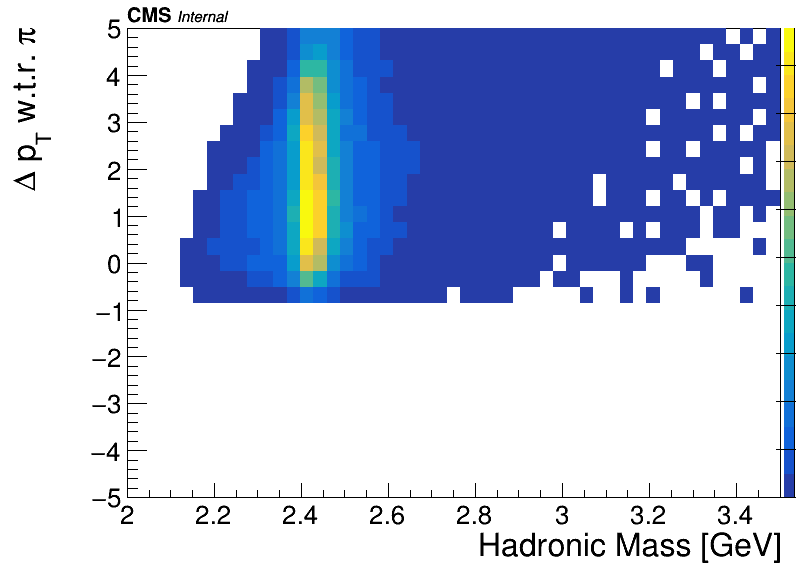

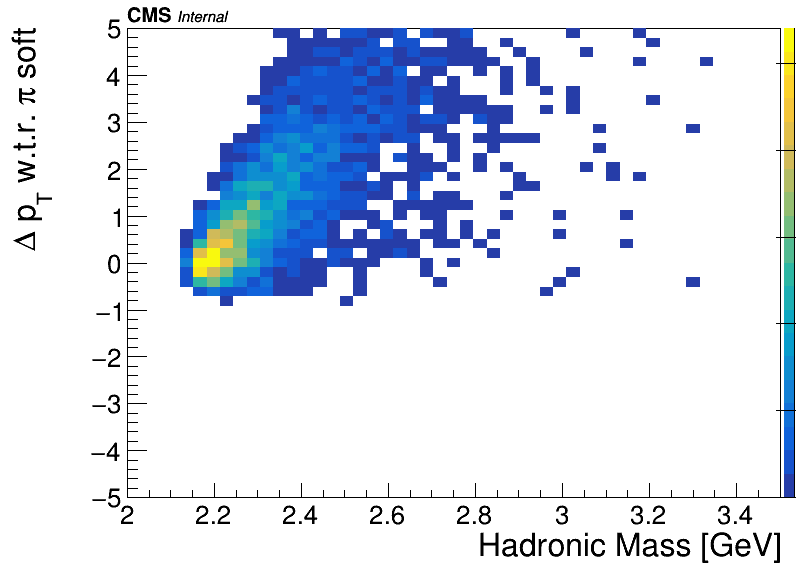

In [22]:
dRDstPi = (df['DstPip']['tkPt_0'][selDstPi] - df['DstPip']['pis_pt'][selDstPi])/df['DstPip']['pis_pt'][selDstPi]
h = create_TH2D(np.column_stack((df['DstPip']['tkMassHad_0'][selDstPi], dRDstPi)), 'DstPip', 
                binning=[np.linspace(2, 3.5, 50), np.linspace(-5, 5, 30)],
                axis_title=['Hadronic Mass [GeV]', '#Delta p_{T} w.t.r. #pi', '']
               )
c = drawOnCMSCanvas(CMS_lumi, [h], ['colz'], tag='DstPip')

dRMu = (df['mu']['tkPt_0'][selMu] - df['mu']['pis_pt'][selMu])/df['mu']['pis_pt'][selMu]
h1 = create_TH2D(np.column_stack((df['mu']['tkMassHad_0'][selMu], dRMu)), 'mu',
                binning=[np.linspace(2, 3.5, 50), np.linspace(-5, 5, 50)],
                axis_title=['Hadronic Mass [GeV]', '#Delta p_{T} w.t.r. #pi soft', '']
               )
c1 = drawOnCMSCanvas(CMS_lumi, [h1], ['colz'], tag='mu')

In [37]:
sel = df['mu']['N_goodAddTks'] == 1
print 'mu: {:.1f} %'.format(100*np.sum(df['mu']['MC_tkFlag_0'][sel] > 0)/float(np.sum(sel)))

sel = df['DstPip']['N_goodAddTks'] == 1
print 'DstPip: {:.1f} %'.format(100*np.sum(df['DstPip']['MC_tkFlag_0'][sel] > 0)/float(np.sum(sel)))

mu: 12.8 %
DstPip: 86.1 %


In [24]:
pdgid2LatexName = {
0: 'N/A',
1: 'd',
-1: '\\bar{d}',
2: 'u',
-2: '\\bar{u}',
3: 's',
-3: '\\bar{s}',
4: 'c',
-4: '\\bar{c}',
5: 'b',
-5: '\\bar{b}',
11: 'e^{-}',
-11: 'e^{-}',
13: '\mu^{-}',
-13: '\mu^{+}',
15: '\\tau^{-}',
-15: '\\tau^{+}',
21: 'g',
22: '\gamma',  
113: '\\rho_{0}',
-113: '\\bar{\\rho}_{0}',
211: '\pi^{+}',
-211: '\pi^{-}',
213: '\\rho^{+}',
-213: '\\rho^{-}',
221: '\eta',
-221: '\\bar{eta}',
223: '\omega',
-223: '\\bar{omega}',
313: 'K^{*}_{0}',
-313: '\\bar{K}^{*}_{0}',
321: 'K^{+}',
-321: 'K^{-}',
323: 'K^{*+}',
-323: 'K^{*-}',
331: '\eta^{\prime}',
-331: '\\bar{eta}^{\prime}',
333: '\phi',
-333: '\\bar{phi}',
411: 'D^{+}',
-411: 'D^{-}',
413: 'D^{*+}',
-413: 'D^{*-}',
415: 'D_{2}^{*+}',
-415: 'D_{2}^{*-}',
421: 'D_{0}',
-421: '\\bar{D}_{0}',
423: 'D_{0}^{*}',
-423: '\\bar{D}_{0}^{*}',
425: 'D_{2}^{*0}',
-425: '\\bar{D}_{2}^{*0}',
431: 'D_{s}^{+}',
-431: 'D_{s}^{-}',
511: 'B_{0}',
-511: '\\bar{B}_{0}',
513: 'B_{0}^{*}',
-513: '\\bar{B}_{0}^{*}',
521: 'B^{+}',
-521: 'B^{-}',
523: 'B^{*+}',
-523: 'B^{*-}',
541: 'B_{c}^{+}',
-541: 'B_{c}^{-}',
543: 'B_{c}^{*+}',
-543: 'B_{c}^{*-}',
2212: 'p',
-2212: '\\bar{p}',
3112: '\Sigma^{-}',
-3112: '\Sigma^{+}',
3312: '\Xi^{-}',
-3312: '\Xi^{+}',
4122: '\Lambda_{c}^{+}',
-4122: '\Lambda_{c}^{-}',
4222: '\Lambda_{c}^{++}',
-4222: '\Lambda_{c}^{--}',
4224: '\Lambda_{c}^{*++}',
-4224: '\Lambda_{c}^{*--}',
10313: 'K_{1}^{0}',
-10313: '\\bar{K}_{1}^{0}',
10423: 'D_{1}^{0}',
-10423: '\\bar{D}_{1}^{0}',
20213: 'a_{1}^{+}',
-20213: 'a_{1}^{-}',
20423: 'D_{1}^{*}',
-20423: '\\bar{D}_{1}^{*0}'
}
# pdgid2LatexName

In [25]:
def plotPdgId(dname, varPdgId, sel=None, logy=False, size=(8,6)):
    if sel is None:
        sel = np.ones_like(df[dname][varPdgId]).astype(np.bool)

    pdgId = {}
    for n in set(df[dname][varPdgId][sel]):
        pdgId[n] = list(df[dname][varPdgId][sel]).count(n)
    print pdgId

    weights = []
    sortedPdgId = np.sort(pdgId.keys())
    for k in sortedPdgId:
        weights.append(pdgId[k])


    n = len(weights)
    fig = plt.figure(figsize=size)
    plt.hist(np.arange(0, n), weights=np.array(weights), range=(-0.5, n-0.5), bins=n);
    plt.xticks(np.arange(0, n), [r'$'+pdgid2LatexName[x]+'$' for x in sortedPdgId])
    if logy: plt.yscale('log')
    plt.ylim(1, plt.ylim()[1]);
    return fig

{321.0: 41, 2212.0: 5, -211.0: 219, 211.0: 55048, -321.0: 47, -2212.0: 22, -13.0: 7}


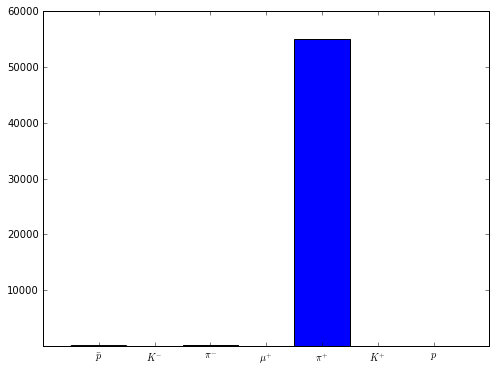

In [26]:
sel = np.logical_and(df['DstPip']['N_goodAddTks'] == 1, df['DstPip']['MC_tkFlag_0'] == 1)
plotPdgId('DstPip', 'MC_tkPdgId_0', sel=sel);

{1.0: 19, 2.0: 16, 3.0: 10, 2212.0: 347, 421.0: 2, -15.0: 1, -10423.0: 25342, -421.0: 25, -425.0: 8300, 333.0: 3, 113.0: 2, 521.0: 7, -20423.0: 21300, -5.0: 15}


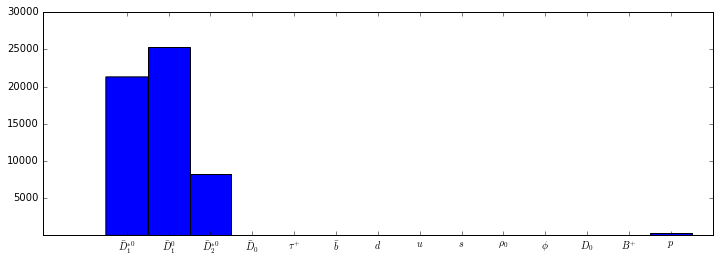

In [27]:
sel = np.logical_and(df['DstPip']['N_goodAddTks'] == 1, df['DstPip']['MC_tkFlag_0'] == 1)
fig = plotPdgId('DstPip', 'MC_tkMotherPdgId_0', sel=sel, size=(12,4))

{321.0: 289, 2212.0: 125, 3112.0: 2, 11.0: 4, -211.0: 1982, 13.0: 3, -3312.0: 1, 211.0: 2924, -11.0: 4, -3112.0: 12, -321.0: 372, -2212.0: 154, -13.0: 23}


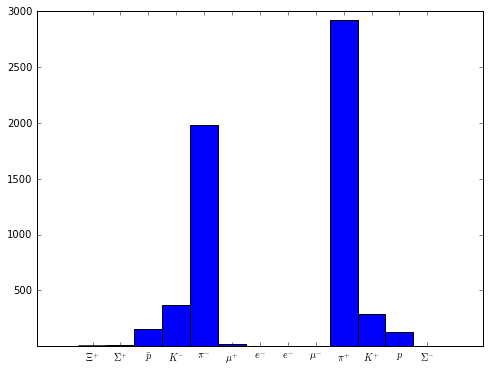

In [28]:
sel = np.logical_and(df['mu']['N_goodAddTks'] == 1, df['mu']['MC_tkFlag_0'] == 1)
plotPdgId('mu', 'MC_tkPdgId_0', sel=sel);

{1.0: 159, 2.0: 166, 3.0: 99, 4.0: 17, 5.0: 141, -511.0: 1, 4122.0: 2, 411.0: 8, 541.0: 2, 2212.0: 4982, 421.0: 11, -213.0: 1, 413.0: 1, -20423.0: 2, 323.0: 2, -313.0: 3, -10423.0: 1, 333.0: 17, -431.0: 1, 213.0: 5, 313.0: 3, -421.0: 14, 221.0: 1, 223.0: 1, -413.0: 23, -411.0: 3, 113.0: 3, -521.0: 1, -5.0: 201, -4.0: 6, 511.0: 18}


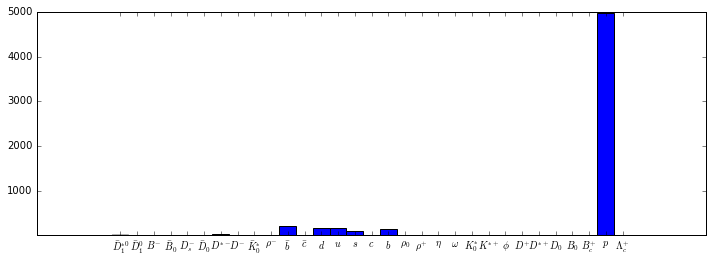

In [29]:
sel = np.logical_and(df['mu']['N_goodAddTks'] == 1, df['mu']['MC_tkFlag_0'] == 1)
fig = plotPdgId('mu', 'MC_tkMotherPdgId_0', sel=sel, size=(12,4))

{0.0: 4982, 513.0: 8, 2.0: 22, 3.0: 14, 4.0: 19, 5.0: 140, 4222.0: 1, 1.0: 9, 521.0: 4, 4224.0: 1, -511.0: 7, 21.0: 4, 411.0: 1, 541.0: 2, 543.0: 1, 2212.0: 362, 421.0: 4, 423.0: 2, 413.0: 6, 10313.0: 1, 331.0: 1, 333.0: 4, -423.0: 3, -421.0: 3, -413.0: 6, 20213.0: 1, 511.0: 23, -5.0: 256, -4.0: 6, -1.0: 1, -513.0: 1}


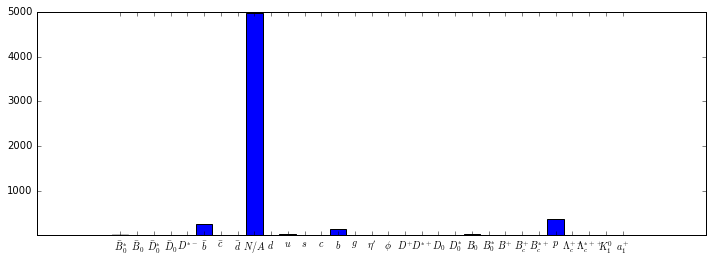

In [30]:
sel = np.logical_and(df['mu']['N_goodAddTks'] == 1, df['mu']['MC_tkFlag_0'] == 1)
fig = plotPdgId('mu', 'MC_tkMotherMotherPdgId_0', sel=sel, size=(12,4))

## All data

In [31]:
RDloc = '../data/cmsRD/skimmed/B2DstMu_200416_{}_skip17_corr.root'.format(cat.name)
df['data'] = pd.DataFrame(rtnp.root2array(RDloc))
datasets_loc = glob('../data/cmsRD/ParkingBPH*/*2018*B2DstMu_200416*')
lumi_tot = getLumiByTrigger(datasets_loc, cat.trg, verbose=True)
CMS_lumi.integrated_lumi = lumi_tot

Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200416
HLT_Mu7_IP4_part2_v2 1.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200416
HLT_Mu7_IP4_part1_v2 1.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200416
HLT_Mu7_IP4_part4_v2 1.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200416
HLT_Mu7_IP4_part3_v2 1.28
Run2018D-05May2019promptD-v1_RDntuplizer_B2DstMu_200416
HLT_Mu7_IP4_part0_v2 1.27
Total lumi: 6.39 fb^-1


## MC comparison

In [32]:
loc = '../data/cmsRD/ParkingBPH{}/Run2018D-05May2019promptD-v1_RDntuplizer_PrescaleVertices_200421_CAND.root'
fAuxPileupRD = []

hPileupTarget = None

for i in range(2, 6):
    fAuxPileupRD.append(rt.TFile.Open(loc.format(i), 'READ'))
    if hPileupTarget is None:
        hPileupTarget = fAuxPileupRD[-1].Get('nVtx/hNvtxPassed'+cat.trg).Clone()
    else:
        hPileupTarget.Add(fAuxPileupRD[-1].Get('nVtx/hNvtxPassed'+cat.trg))

hPileupTarget.Scale(1./hPileupTarget.Integral())

fAuxPileupMC = rt.TFile.Open(MCsample['mu'].skimmed_dir + '/{}_corr.root'.format(cat.name), 'READ')
hPileupGen = fAuxPileupMC.Get('hAllNvtx')
hPileupGen.Scale(1./hPileupGen.Integral())

weights = np.ones(hPileupGen.GetNbinsX())
s = 0
for i in range(weights.shape[0]):
    if hPileupGen.GetBinContent(i+1) == 0:
        continue
    weights[i] = hPileupTarget.GetBinContent(i+1)/hPileupGen.GetBinContent(i+1)
    s += hPileupGen.GetBinContent(i+1) * weights[i]

weightsPileupMC = weights/s

for f in fAuxPileupRD + [fAuxPileupMC]:
    f.Close()

def getPileupWeights(ds, selection=None):
    x = ds['N_vtx']
    if not selection is None:
        x = x[selection]
    return weightsPileupMC[x.astype(np.int)]

In [33]:
baseSelMC = np.logical_and(df['mu']['N_goodAddTks'] == 1, df['mu']['tkCharge_0'] == -1)
baseSelRD = np.logical_and(df['data']['N_goodAddTks'] == 1, df['data']['tkCharge_0'] == -1)

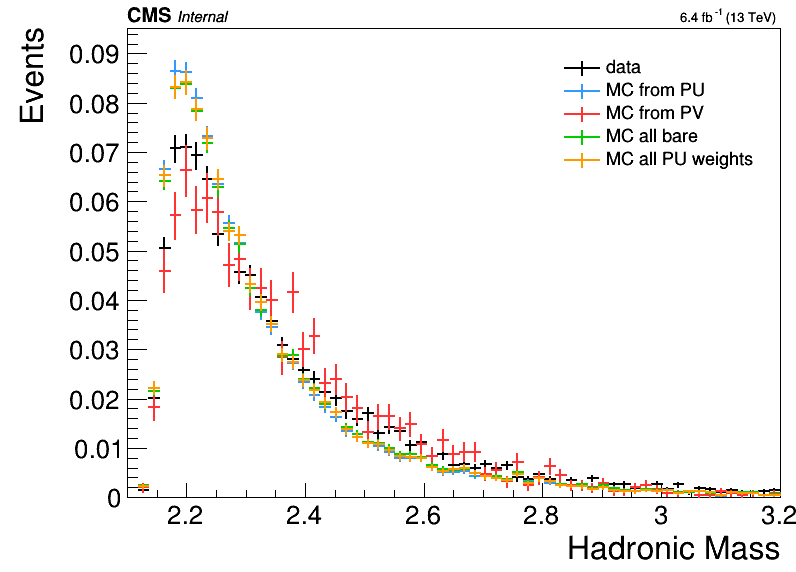

In [34]:
leg = rt.TLegend(0.7, 0.7, 0.95, 0.9)
leg.SetBorderSize(0)
leg.SetTextFont(42)

hlist = []

h = create_TH1D(df['data']['tkMassHad_0'][baseSelRD], binning=[61, 2.1, 3.2], 
                axis_title=['Hadronic Mass', 'Events'], scale_histo='norm')
leg.AddEntry(h, 'data', 'lep')
hlist.append(h)

sel = np.logical_and(baseSelMC, df['mu']['MC_tkFlag_0'] == -1)
h = create_TH1D(df['mu']['tkMassHad_0'][sel], binning=h.binning, scale_histo='norm', color=0)
leg.AddEntry(h, 'MC from PU', 'lep')
hlist.append(h)

sel = np.logical_and(baseSelMC, df['mu']['MC_tkFlag_0'] == 1)
h = create_TH1D(df['mu']['tkMassHad_0'][sel], binning=h.binning, scale_histo='norm', color=1)
leg.AddEntry(h, 'MC from PV', 'lep')
hlist.append(h)

h = create_TH1D(df['mu']['tkMassHad_0'][baseSelMC], binning=h.binning, scale_histo='norm', color=2)
leg.AddEntry(h, 'MC all bare', 'lep')
hlist.append(h)

h = create_TH1D(df['mu']['tkMassHad_0'][baseSelMC],
                weights=getPileupWeights(df['mu'], selection=baseSelMC),
                binning=h.binning, scale_histo='norm', color=3)
leg.AddEntry(h, 'MC all PU weights', 'lep')
hlist.append(h)

m = SetMaxToMaxHist(hlist)
drawOnCMSCanvas(CMS_lumi, hlist, 'same')
# hlist[0].GetYaxis().SetRangeUser(1e-5, m)
leg.Draw()
# c.SetLogy()

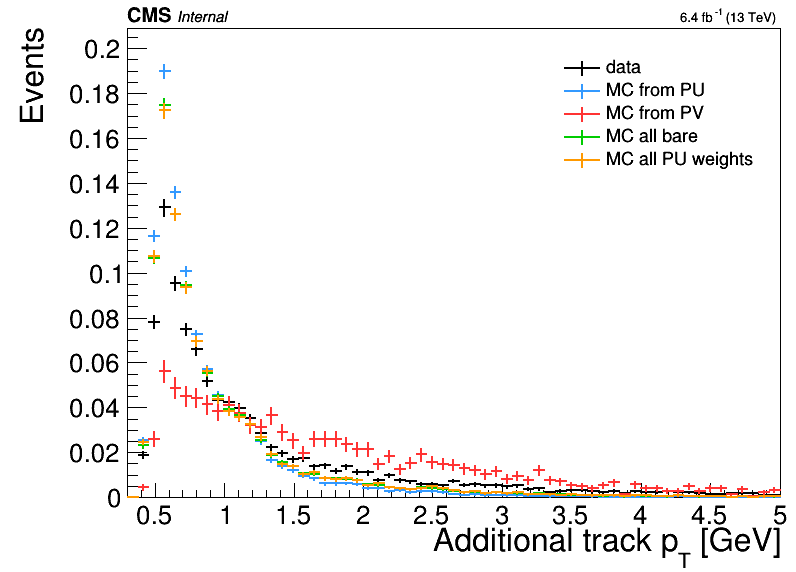

In [35]:
leg = rt.TLegend(0.7, 0.7, 0.95, 0.9)
leg.SetBorderSize(0)
leg.SetTextFont(42)
var = 'tkPt_0'

hlist = []

h = create_TH1D(df['data'][var][baseSelRD], binning=[61, 0.3, 5.0], 
                axis_title=['Additional track p_{T} [GeV]', 'Events'], scale_histo='norm')
leg.AddEntry(h, 'data', 'lep')
hlist.append(h)

sel = np.logical_and(baseSelMC, df['mu']['MC_tkFlag_0'] == -1)
h = create_TH1D(df['mu'][var][sel], binning=h.binning, scale_histo='norm', color=0)
leg.AddEntry(h, 'MC from PU', 'lep')
hlist.append(h)

sel = np.logical_and(baseSelMC, df['mu']['MC_tkFlag_0'] == 1)
h = create_TH1D(df['mu'][var][sel], binning=h.binning, scale_histo='norm', color=1)
leg.AddEntry(h, 'MC from PV', 'lep')
hlist.append(h)

h = create_TH1D(df['mu'][var][baseSelMC], binning=h.binning, scale_histo='norm', color=2)
leg.AddEntry(h, 'MC all bare', 'lep')
hlist.append(h)

h = create_TH1D(df['mu'][var][baseSelMC],
                weights=getPileupWeights(df['mu'], selection=baseSelMC),
                binning=h.binning, scale_histo='norm', color=3)
leg.AddEntry(h, 'MC all PU weights', 'lep')
hlist.append(h)

m = SetMaxToMaxHist(hlist)
drawOnCMSCanvas(CMS_lumi, hlist, 'same')
# hlist[0].GetYaxis().SetRangeUser(1e-5, m)
leg.Draw()
# c.SetLogy()

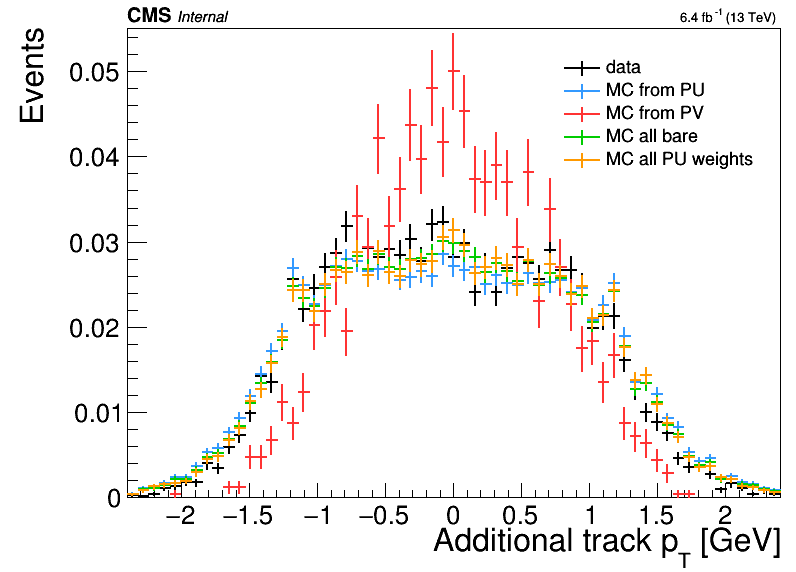

In [36]:
leg = rt.TLegend(0.7, 0.7, 0.95, 0.9)
leg.SetBorderSize(0)
leg.SetTextFont(42)
var = 'tkEta_0'

hlist = []

h = create_TH1D(df['data'][var][baseSelRD], binning=[61, -2.4, 2.4], 
                axis_title=['Additional track p_{T} [GeV]', 'Events'], scale_histo='norm')
leg.AddEntry(h, 'data', 'lep')
hlist.append(h)

sel = np.logical_and(baseSelMC, df['mu']['MC_tkFlag_0'] == -1)
h = create_TH1D(df['mu'][var][sel], binning=h.binning, scale_histo='norm', color=0)
leg.AddEntry(h, 'MC from PU', 'lep')
hlist.append(h)

sel = np.logical_and(baseSelMC, df['mu']['MC_tkFlag_0'] == 1)
h = create_TH1D(df['mu'][var][sel], binning=h.binning, scale_histo='norm', color=1)
leg.AddEntry(h, 'MC from PV', 'lep')
hlist.append(h)

h = create_TH1D(df['mu'][var][baseSelMC], binning=h.binning, scale_histo='norm', color=2)
leg.AddEntry(h, 'MC all bare', 'lep')
hlist.append(h)

h = create_TH1D(df['mu'][var][baseSelMC],
                weights=getPileupWeights(df['mu'], selection=baseSelMC),
                binning=h.binning, scale_histo='norm', color=3)
leg.AddEntry(h, 'MC all PU weights', 'lep')
hlist.append(h)

m = SetMaxToMaxHist(hlist)
drawOnCMSCanvas(CMS_lumi, hlist, 'same')
# hlist[0].GetYaxis().SetRangeUser(1e-5, m)
leg.Draw()
# c.SetLogy()